In [33]:
import os
from PIL import Image
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import pytorch_lightning as pl
import numpy as np
import math
import sys
import math

In [34]:
patch_size = (16, 16)      # Tamaño de cada patch (afecta n_embd)
img_size = (224, 224)      # Resolución de entrada (afecta seq_len)
batch_size = 16            # Tamaño del batch (afecta memoria)

n_embd = 3 * 16 * 16       # 768 - Dimensiones del embedding por patch
seq_len = 14 * 14          # 196 - Número total de patches
n_heads = 4*4               # Número de cabezas de atención
num_classes = 5            # Número de clases de tu dataset
dropout = 0.3              # Regularización para evitar overfitting

learning_rate = 1e-4       # Tasa de aprendizaje
weight_decay = 1e-4        # Regularización L2
optimizer = "AdamW"        # Optimizador (Adam, AdamW, SGD)

max_epochs = 3             # Épocas máximas
precision = 32             # Precisión (16 para GPU, 32 para CPU)
accumulate_grad_batches = 1 # Acumulación de gradientes

In [35]:
class LazyAttnDataset(Dataset):
    def __init__(self, data_dir, patch_size=(16, 16), img_size=(224, 224)):
        self.files, self.labels = [], []
        self.patch_size = patch_size
        self.img_size = img_size
        
        for label, classname in enumerate(sorted(os.listdir(data_dir))):
            class_dir = os.path.join(data_dir, classname)
            if not os.path.isdir(class_dir):
                continue
            for fname in os.listdir(class_dir):
                if fname.lower().endswith(('.png', '.jpg', '.jpeg')):
                    self.files.append(os.path.join(class_dir, fname))
                    self.labels.append(label)

    def __len__(self):
        return len(self.files)

    def __getitem__(self, ix):
        img = Image.open(self.files[ix]).convert("RGB")
        img = img.resize(self.img_size)
        img = torch.tensor(np.array(img)).float().permute(2, 0, 1) / 255
        
        C, H, W = img.shape
        hh, ww = self.patch_size
        
        # Verificar que las dimensiones sean divisibles
        assert H % hh == 0, f"Height {H} not divisible by patch height {hh}"
        assert W % ww == 0, f"Width {W} not divisible by patch width {ww}"
        
        patches = img.unfold(1, hh, hh).unfold(2, ww, ww)
        patches = patches.permute(1, 2, 0, 3, 4).contiguous()
        patches = patches.view(-1, C * hh * ww)
        label = torch.tensor(self.labels[ix]).long()
        
        return patches, label


In [36]:
from torch.utils.data import DataLoader

train_dataset = LazyAttnDataset(r"D:\Ciencias\Dataset Residuos solidos\data\train", patch_size=patch_size, img_size=img_size)
val_dataset = LazyAttnDataset(r"D:\Ciencias\Dataset Residuos solidos\data\val", patch_size=patch_size, img_size=img_size)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [37]:
# Tomar un batch
imgs, labels = next(iter(train_loader))  # imgs.shape = [batch_size, C, H, W]

print("Batch shape:", imgs.shape)  # e.g., [32, 3, 224, 224]

# Aplanar cada imagen del batch
imgs_flat = imgs.view(imgs.size(0), -1)
print("Batch aplanado:", imgs_flat.shape)  # e.g., [32, 150528]

# Mostrar la primera imagen
print("Primera imagen (tensor):")
print(imgs[0])  # shape [3, 224, 224]

print("#"*30)

# Primera imagen aplanada
print("Primera imagen aplanada:")
print(imgs_flat[0])  # shape [150528]


Batch shape: torch.Size([16, 196, 768])
Batch aplanado: torch.Size([16, 150528])
Primera imagen (tensor):
tensor([[0.0627, 0.0863, 0.1294,  ..., 0.1569, 0.1569, 0.1490],
        [0.4471, 0.4588, 0.4588,  ..., 0.3804, 0.3961, 0.3843],
        [0.4784, 0.4667, 0.4627,  ..., 0.1725, 0.1647, 0.1529],
        ...,
        [0.1137, 0.1216, 0.1412,  ..., 0.0902, 0.1020, 0.0980],
        [0.1294, 0.1176, 0.1137,  ..., 0.0863, 0.0824, 0.1059],
        [0.1137, 0.1216, 0.1176,  ..., 0.0980, 0.0941, 0.0941]])
##############################
Primera imagen aplanada:
tensor([0.0627, 0.0863, 0.1294,  ..., 0.0980, 0.0941, 0.0941])


In [38]:
class DesechosDataModule(pl.LightningDataModule):
    def __init__(self, batch_size=16, patch_size=(16, 16), img_size=(224, 224)):
        super().__init__()
        self.batch_size = batch_size
        self.patch_size = patch_size
        self.img_size = img_size

    def setup(self, stage=None):
        self.train_ds = LazyAttnDataset(
            r"D:\Ciencias\Dataset Residuos solidos\data\train",
            patch_size=self.patch_size,
            img_size=self.img_size
        )
        self.val_ds = LazyAttnDataset(
            r"D:\Ciencias\Dataset Residuos solidos\data\val",
            patch_size=self.patch_size,
            img_size=self.img_size
        )

    def train_dataloader(self):
        return DataLoader(self.train_ds, batch_size=self.batch_size, shuffle=True)

    def val_dataloader(self):
        return DataLoader(self.val_ds, batch_size=self.batch_size)

In [39]:
imgsprueba = torch.rand(3,224,224)
print(imgsprueba.shape)

torch.Size([3, 224, 224])


In [40]:
#Creamos una imagen de prueba random
imgsprueba = torch.rand(3,224,224)  # RGB
C, H, W = imgsprueba.shape

#Definimos el tamaño de los patches
hh, ww = 16, 16

#Divide la imagen en patches no superpuestos de tamaño (hh, ww)
patches = imgsprueba.unfold(1, hh, hh).unfold(2, ww, ww)  # (C, 14, 14, 16, 16)
print(patches.shape)

#Reorganiza los parches para tenerlos en la forma (14, 14, C, 16, 16)
patches = patches.permute(1, 2, 0, 3, 4).contiguous()      # (14, 14, C, 16, 16)
print(patches.shape)

#Aplana cada parche a un vector de tamaño C*hh*ww
patches_flat = patches.view(-1, C*hh*ww) # (196, 768) (n_patches, patch_size)
print(patches_flat.shape)


torch.Size([3, 14, 14, 16, 16])
torch.Size([14, 14, 3, 16, 16])
torch.Size([196, 768])


In [41]:
#creamos el datamodule
attn_dm = DesechosDataModule(batch_size=batch_size, patch_size=patch_size, img_size=img_size)

#Configuramos el datamodule usando internamente el AttnDataset
attn_dm.setup()

In [42]:
#Probamos el dataloader

imgs, labels = next(iter(attn_dm.train_dataloader())) #obtenemos un batch

#Comprobamos las dimensiones
imgs.shape, labels.shape

(torch.Size([16, 196, 768]), torch.Size([16]))

Epoch 4:  17%|█▋        | 437/2501 [06:54<32:39,  1.05it/s, v_num=4, train_loss=0.220, train_acc=0.875, val_loss=0.390, val_acc=0.911] 


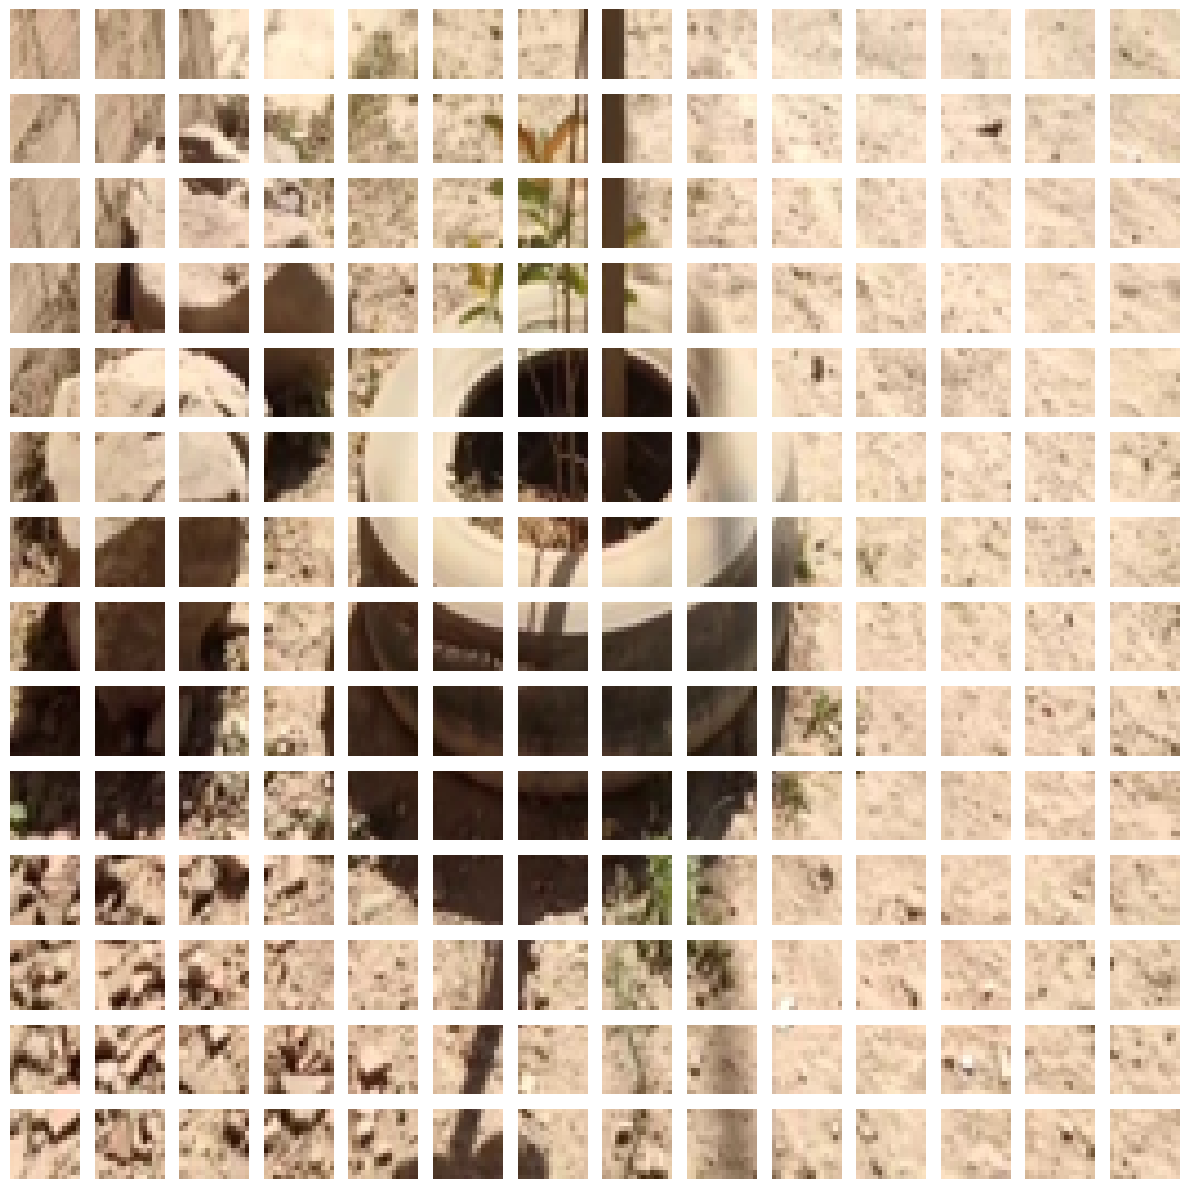

In [43]:
import matplotlib.pyplot as plt

# Tomamos un batch
patches_batch, labels = next(iter(attn_dm.train_dataloader()))  # (B, num_patches, C*hh*ww)
hh, ww = 16, 16 
C = 3

# Primer ejemplo del batch
patches = patches_batch[0]  # (196, 768)

# Grid 14x14 de todos los patches5
fig = plt.figure(figsize=(12,12))
for i in range(14):
    for j in range(14):
        idx = i*14 + j
        patch_flat = patches[idx]            # (768,)
        patch = patch_flat.view(C, hh, ww)   # (3,16,16)
        patch = patch.permute(1, 2, 0)       # (16,16,3)
        ax = plt.subplot(14, 14, idx+1)
        ax.imshow(patch.numpy())
        ax.axis('off')

plt.tight_layout()
plt.show()


In [44]:
class MultiHeadAttention(torch.nn.Module):

    def __init__(self, n_embd, n_heads):
        super().__init__()
        self.n_heads = n_heads
        self.head_dim = n_embd // n_heads
        
        assert n_embd % n_heads == 0, "n_embd must be divisible by n_heads"
        
        # Proyección combinada QKV (más eficiente en memoria)
        
        self.query = nn.Linear(n_embd, n_embd * n_heads)
        self.key = nn.Linear(n_embd, n_embd * n_heads)
        self.value = nn.Linear(n_embd, n_embd * n_heads)
        
        
        # self.qkv = nn.Linear(n_embd, 3 * n_embd)
        self.proj = nn.Linear(n_embd*n_heads, n_embd)
        
        self.attn_dropout = nn.Dropout(dropout)
        self.proj_dropout = nn.Dropout(dropout)
        
        # self.scale = 1.0 / math.sqrt(self.head_dim)

    def forward(self, x):
        B, L, F = x.size()
        
        # QKV en una sola operación
        # qkv = self.qkv(x).reshape(B, L, 3, self.n_heads, self.head_dim).permute(2, 0, 3, 1, 4)
        # q, k, v = qkv[0], qkv[1], qkv[2]
        
        # calculate query, key, values for all heads in batch and move head forward to be the batch dim
        k = self.key(x).view(B, L, F, self.n_heads).transpose(1, 3) # (B, nh, L, F)
        q = self.query(x).view(B, L, F, self.n_heads).transpose(1, 3) # (B, nh, L, F)
        v = self.value(x).view(B, L, F, self.n_heads).transpose(1, 3) # (B, nh, L, F)

        # Atención escalada
        # attn = (q @ k.transpose(-2, -1)) * self.scale
        attn = (q @ k.transpose(-2, -1)) * (1.0 / math.sqrt(k.size(-1)))
        attn = attn.softmax(dim=-1)
        attn = self.attn_dropout(attn)
        
        # Aplicar atención
        y = attn @ v
        # y = y.transpose(1, 2).reshape(B, L, C)
        y = y.transpose(1, 2).contiguous().view(B, L, F*self.n_heads)
        
        return self.proj_dropout(self.proj(y))

In [ ]:
class EnhancedAttentionModel(pl.LightningModule):
    def __init__(self, n_embd=768, seq_len=196, n_heads=16, num_classes=5, dropout=0.3):
        super().__init__()
        self.save_hyperparameters()
        
        # Bloques de atención
        self.attn1 = MultiHeadAttention(n_embd, n_heads)
        self.ln1 = nn.LayerNorm(n_embd)
        self.dropout1 = nn.Dropout(dropout)
        
        self.attn2 = MultiHeadAttention(n_embd, n_heads)
        self.ln2 = nn.LayerNorm(n_embd)
        self.dropout2 = nn.Dropout(dropout)
        
        # MLP CORREGIDO: debe aceptar n_embd * seq_len
        self.mlp_head = nn.Sequential(
            nn.Linear(n_embd * seq_len, 512),  # ← ¡CORRECCIÓN IMPORTANTE!
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(512, 256),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(256, num_classes)
        )
        
        self.criterion = nn.CrossEntropyLoss()

    def forward(self, x):
        B, L, C = x.size()
        
        # Primer bloque
        x_attn = self.attn1(x)
        x = self.ln1(x + self.dropout1(x_attn))
        
        # Segundo bloque
        x_attn = self.attn2(x)
        x = self.ln2(x + self.dropout2(x_attn))
        
        # Aplanar toda la secuencia (batch_size, n_embd * seq_len)
        x = x.reshape(B, -1)
        return self.mlp_head(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = self.criterion(y_hat, y)
        acc = (y_hat.argmax(dim=1) == y).float().mean()
        
        self.log('train_loss', loss, prog_bar=True)
        self.log('train_acc', acc, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = self.criterion(y_hat, y)
        acc = (y_hat.argmax(dim=1) == y).float().mean()
        
        self.log('val_loss', loss, prog_bar=True)
        self.log('val_acc', acc, prog_bar=True)
        return loss

    def configure_optimizers(self):
        return torch.optim.Adam(
            self.parameters(), 
            lr=1e-4,
            weight_decay=1e-4
        )

In [46]:
C = 3  # RGB

n_embd = C * patch_size[0] * patch_size[1]  # 3 * 16 * 16 = 768
seq_len = (img_size[0] // patch_size[0]) * (img_size[1] // patch_size[1])  # 14 * 14 = 196

print(f"Calculated dimensions:")
print(f"n_embd: {n_embd}")
print(f"seq_len: {seq_len}")
print(f"MLP input: {n_embd * seq_len}")  # 768 * 196 = 150528

Calculated dimensions:
n_embd: 768
seq_len: 196
MLP input: 150528


In [47]:
attn_dm = DesechosDataModule(
    batch_size=batch_size,
    patch_size=patch_size,
    img_size=img_size
)
attn_dm.setup()

model = EnhancedAttentionModel(
    n_embd=n_embd,
    seq_len=seq_len,
    n_heads=n_heads,
    num_classes=num_classes,
    dropout=dropout
)

trainer = pl.Trainer(
    max_epochs=max_epochs,  # Más épocas para mejor convergencia
    precision=16 if torch.cuda.is_available() else 32,
    accumulate_grad_batches=2,
    gradient_clip_val=1.0,
    enable_progress_bar=True,
    enable_model_summary=True,
    deterministic=True
)

trainer.fit(model, attn_dm)

d:\Programs\Python\3.12.7\Lib\site-packages\lightning_fabric\connector.py:571: `precision=16` is supported for historical reasons but its usage is discouraged. Please set your precision to 16-mixed instead!
Using 16bit Automatic Mixed Precision (AMP)
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
d:\Programs\Python\3.12.7\Lib\site-packages\pytorch_lightning\utilities\model_summary\model_summary.py:231: Precision 16-mixed is not supported by the model summary.  Estimated model size in MB will not be accurate. Using 32 bits instead.

  | Name      | Type               | Params | Mode 
---------------------------------------------------------
0 | attn1     | MultiHeadAttention |

Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

d:\Programs\Python\3.12.7\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:433: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


RuntimeError: Given normalized_shape=[768], expected input with shape [*, 768], but got input of size[16, 150528]

In [16]:
import torch

def save_model_with_metadata(model, trainer, config, save_path="model_with_metadata.pth"):
    checkpoint = {
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': trainer.optimizers[0].state_dict(),
        'hyperparameters': config,
        'epoch': trainer.current_epoch,
        'val_acc': trainer.callback_metrics.get('val_acc', 0.0),
        'val_loss': trainer.callback_metrics.get('val_loss', 0.0)
    }
    
    torch.save(checkpoint, save_path)
    print(f"Modelo con metadata guardado como: {save_path}")
    return save_path


In [ ]:
# import sys
# import os

# # sys.path.append(os.path.abspath("."))
# # from functions.save_model import save_model_with_metadata

save_path = "desechos_model_2.pth"
config = {
    'patch_size': patch_size,
    'img_size': img_size,
    'n_embd': n_embd,
    'seq_len': seq_len,
    'num_classes': 5,
    'batch_size': batch_size,
    'max_epochs': max_epochs
}

metadata_path = save_model_with_metadata(model, trainer, config, save_path=save_path)

Modelo con metadata guardado como: desechos_model_1.pth
